In [1]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(suppress=True)

import seaborn as sns
%matplotlib inline

In [2]:
files = glob.glob('./dat/*')

len(files)

29406

In [3]:
file = files[100]

with open(file, 'r') as fp:
    match = json.load(fp)

In [4]:
match.keys()

dict_keys(['gameId', 'platformId', 'gameCreation', 'gameDuration', 'queueId', 'mapId', 'seasonId', 'gameVersion', 'gameMode', 'gameType', 'teams', 'participants', 'participantIdentities'])

In [5]:
match['participants'][0].keys()

dict_keys(['participantId', 'teamId', 'championId', 'spell1Id', 'spell2Id', 'highestAchievedSeasonTier', 'stats', 'timeline'])

In [50]:
team_stats_vars = ['firstBlood','firstTower','firstDragon','firstRiftHerald','firstInhibitor','firstBaron']

# inhibitor is well inside base; late-game predictor
# baron spawns at 20:00
# dragon spawns at 2:30 (http://leagueoflegends.wikia.com/wiki/Dragon)
# rift herald spawns at 9:50 (http://leagueoflegends.wikia.com/wiki/Rift_Herald)
# baron spawns at 20:00 http://leagueoflegends.wikia.com/wiki/Baron_Nashor

def get_team_stats(match):
    team_0_stats = np.array([1*match['teams'][0][var] for var in team_stats_vars])
    team_1_stats = np.array([1*match['teams'][1][var] for var in team_stats_vars])
    team_diff = team_0_stats - team_1_stats
    return team_diff

In [22]:
def seconds_to_duration_category(seconds):
    """
    returns duration
    0: ['0-10'],
    1: ['0-10','10-20'],
    2: ['0-10','10-20','20-30']
    """
    mins = seconds/60
    return int(mins/10)-1

In [25]:
team_stats = []
winners = []
duration = 1

for i, file in enumerate(files):
    if i == 5000:
        break
    if i % 100 == 0:
        print(i)
    with open(file, 'r') as fp:
        match = json.load(fp)
        if match['seasonId'] == 11:
            seconds = match['gameDuration']
            if seconds_to_duration_category(seconds) >= duration:
                try:
                    cur_team_stats = get_team_stats(match)
                    team_stats.append(cur_team_stats)
                    winner = (match['teams'][0]['win'] == 'Fail')*1
                    winners.append(winner)
                except:
                    print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [26]:
[print(len(x)) for x in [winners, team_stats]]

3873
3873


[None, None]

In [30]:
n = len(team_stats)
team_stats_array = np.array(team_stats).reshape((n,6))
winners = np.array(winners)
winners = winners.reshape((winners.shape[0],1))

In [51]:
labels = team_stats_vars
labels.append('winner')
print(labels)

['firstBlood', 'firstTower', 'firstDragon', 'firstRiftHerald', 'firstInhibitor', 'firstBaron', 'winner']


In [52]:
df = pd.DataFrame(np.concatenate((team_stats_array, winners),axis=1),columns=labels)

In [53]:
df

,firstBlood,firstTower,firstDragon,firstRiftHerald,firstInhibitor,firstBaron,winner
0,-1,-1,0,0,-1,0,1
1,-1,1,0,0,1,0,1
2,1,-1,1,-1,1,-1,0
3,-1,-1,-1,-1,-1,-1,1
4,1,1,1,0,-1,-1,0
5,-1,-1,0,-1,-1,-1,1
6,-1,-1,-1,0,-1,-1,1
7,1,1,-1,1,0,0,1
8,-1,1,-1,1,-1,-1,1
9,1,-1,-1,0,1,1,0


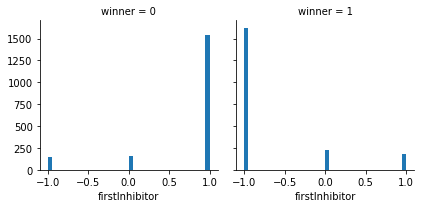

In [55]:
g = sns.FacetGrid(df, col='winner')
g.map(plt.hist, 'firstInhibitor', bins=40)

In [59]:
from sklearn.metrics import accuracy_score

def runModel(model, X_train, Y_train, X_test):
    """
    performs fitting of [model] using [X_train] and [Y_train]
    returns accuracy on training set, and predictions on [X_test]
    """
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    accuracy = round(model.score(X_train, Y_train) * 100, 2)
    return accuracy, Y_pred

def runLogisticRegression(X_train, Y_train, X_test):
    """
    runs logistic regression
    returns accuracy on training set, and predictions
    """
    from sklearn.linear_model import LogisticRegression
    
    logreg = LogisticRegression()
    return runModel(logreg, X_train, Y_train, X_test)

def runSVM(X_train, Y_train, X_test):
    """
    runs support vector machine
    returns accuracy on training set, and predictions
    """
    from sklearn.svm import SVC
    
    svc = SVC()
    return runModel(svc, X_train, Y_train, X_test)

def runRandomForest(X_train, Y_train, X_test, n_estimators = 300):
    """
    runs random forest with [n_estimators] estimators
    returns accuracy on training set, and predictions
    """

    from sklearn.ensemble import RandomForestClassifier

    random_forest = RandomForestClassifier(n_estimators=300)
    return runModel(random_forest, X_train, Y_train, X_test)

In [69]:
from sklearn.model_selection import train_test_split

#['firstBlood','firstTower','firstDragon','firstRiftHerald','firstInhibitor','firstBaron']

# inhibitor is well inside base; late-game predictor
# baron spawns at 20:00
# dragon spawns at 2:30 (http://leagueoflegends.wikia.com/wiki/Dragon)
# rift herald spawns at 9:50 (http://leagueoflegends.wikia.com/wiki/Rift_Herald)
# baron spawns at 20:00 http://leagueoflegends.wikia.com/wiki/Baron_Nashor

X = df[['firstBlood','firstTower','firstDragon', 'firstRiftHerald','firstBaron','firstInhibitor']]

X_train, X_test, y_train, y_test = train_test_split(X, df[['winner']], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df[['td_0-10']], df[['winner']], test_size=0.33, random_state=42)
acc, y_pred = runLogisticRegression(X_train, y_train, X_test)
print('train:' ,acc, '\ntest: ' ,accuracy_score(y_test, y_pred)*100)

train: 89.9 
test:  89.41935483870968


/Users/ccl/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
